<a href="https://colab.research.google.com/github/Gratisfo/neural_networks/blob/main/Homework2_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch


In [79]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [5]:
!unzip processed_corpus.json.zip

Archive:  processed_corpus.json.zip
  inflating: processed_corpus.json   


In [6]:
with open('processed_corpus.json') as f:
    corpus = json.load(f)

In [7]:
len(corpus)

100000

In [8]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [9]:
sample_text = corpus[0]

In [10]:
' '.join(sample_text)

'второй UNK год окончательно разочаровать решить податься альфабанк'

# Реализуйте разделение предложения на примеры методом CBOW

In [11]:
def cbow_split(tokens, window, pad_token='PAD'):
    text = [t for t in tokens]
    splits = []
    len_ = len(text)
    for w in range(window):
      text.append(pad_token)
    for idx in range(len_):
      left = idx - window
      l = [text[i] for i in range(left, idx)]
      right = idx + window
      r = [text[i+1] for i in range(idx, right) if i <= len(text)]

      context = (l, text[idx], r)
      splits.append(context)    
    return splits

In [12]:
splits = cbow_split(sample_text, window=2)

In [13]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: второй
Правый контекст: ['UNK', 'год']

Левый контекст: ['PAD', 'второй']
Центральное слово: UNK
Правый контекст: ['год', 'окончательно']

Левый контекст: ['второй', 'UNK']
Центральное слово: год
Правый контекст: ['окончательно', 'разочаровать']

Левый контекст: ['UNK', 'год']
Центральное слово: окончательно
Правый контекст: ['разочаровать', 'решить']

Левый контекст: ['год', 'окончательно']
Центральное слово: разочаровать
Правый контекст: ['решить', 'податься']

Левый контекст: ['окончательно', 'разочаровать']
Центральное слово: решить
Правый контекст: ['податься', 'альфабанк']

Левый контекст: ['разочаровать', 'решить']
Центральное слово: податься
Правый контекст: ['альфабанк', 'PAD']

Левый контекст: ['решить', 'податься']
Центральное слово: альфабанк
Правый контекст: ['PAD', 'PAD']



In [14]:
splits

[(['PAD', 'PAD'], 'второй', ['UNK', 'год']),
 (['PAD', 'второй'], 'UNK', ['год', 'окончательно']),
 (['второй', 'UNK'], 'год', ['окончательно', 'разочаровать']),
 (['UNK', 'год'], 'окончательно', ['разочаровать', 'решить']),
 (['год', 'окончательно'], 'разочаровать', ['решить', 'податься']),
 (['окончательно', 'разочаровать'], 'решить', ['податься', 'альфабанк']),
 (['разочаровать', 'решить'], 'податься', ['альфабанк', 'PAD']),
 (['решить', 'податься'], 'альфабанк', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [15]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'второй', ['UNK', 'год', 'окончательно']),
 (['PAD', 'PAD', 'второй'], 'UNK', ['год', 'окончательно', 'разочаровать']),
 (['PAD', 'второй', 'UNK'], 'год', ['окончательно', 'разочаровать', 'решить']),
 (['второй', 'UNK', 'год'],
  'окончательно',
  ['разочаровать', 'решить', 'податься']),
 (['UNK', 'год', 'окончательно'],
  'разочаровать',
  ['решить', 'податься', 'альфабанк']),
 (['год', 'окончательно', 'разочаровать'],
  'решить',
  ['податься', 'альфабанк', 'PAD']),
 (['окончательно', 'разочаровать', 'решить'],
  'податься',
  ['альфабанк', 'PAD', 'PAD']),
 (['разочаровать', 'решить', 'податься'], 'альфабанк', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [16]:
' '.join(corpus[0])

'второй UNK год окончательно разочаровать решить податься альфабанк'

# Реализуйте разделение предложения на примеры методом Skipgram

In [17]:
def skipgram_split(tokens, window):
    
    splits = []
  
    for idx, token in enumerate(tokens):
        begin = idx - window  
        end = idx + 1 + window  

        if end >= len(tokens):
            end = len(tokens)
        if begin <= 0:
            begin = 0
      
        context = tokens[begin:end]

        for word in context:
            if word != token:
              skip = (word, token)
              splits.append(skip)
    
    return splits

In [18]:
splits = skipgram_split(sample_text, window=2)

In [19]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: UNK
Центральное слово: второй

Контекст: год
Центральное слово: второй

Контекст: второй
Центральное слово: UNK

Контекст: год
Центральное слово: UNK

Контекст: окончательно
Центральное слово: UNK

Контекст: второй
Центральное слово: год

Контекст: UNK
Центральное слово: год

Контекст: окончательно
Центральное слово: год

Контекст: разочаровать
Центральное слово: год

Контекст: UNK
Центральное слово: окончательно

Контекст: год
Центральное слово: окончательно

Контекст: разочаровать
Центральное слово: окончательно

Контекст: решить
Центральное слово: окончательно

Контекст: год
Центральное слово: разочаровать

Контекст: окончательно
Центральное слово: разочаровать

Контекст: решить
Центральное слово: разочаровать

Контекст: податься
Центральное слово: разочаровать

Контекст: окончательно
Центральное слово: решить

Контекст: разочаровать
Центральное слово: решить

Контекст: податься
Центральное слово: решить

Контекст: альфабанк
Центральное слово: решить

Контекст: разочароват

In [20]:
skipgram_split(sample_text, window=2)

[('UNK', 'второй'),
 ('год', 'второй'),
 ('второй', 'UNK'),
 ('год', 'UNK'),
 ('окончательно', 'UNK'),
 ('второй', 'год'),
 ('UNK', 'год'),
 ('окончательно', 'год'),
 ('разочаровать', 'год'),
 ('UNK', 'окончательно'),
 ('год', 'окончательно'),
 ('разочаровать', 'окончательно'),
 ('решить', 'окончательно'),
 ('год', 'разочаровать'),
 ('окончательно', 'разочаровать'),
 ('решить', 'разочаровать'),
 ('податься', 'разочаровать'),
 ('окончательно', 'решить'),
 ('разочаровать', 'решить'),
 ('податься', 'решить'),
 ('альфабанк', 'решить'),
 ('разочаровать', 'податься'),
 ('решить', 'податься'),
 ('альфабанк', 'податься'),
 ('решить', 'альфабанк'),
 ('податься', 'альфабанк')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [21]:
skipgram_split(sample_text, window=3)

[('UNK', 'второй'),
 ('год', 'второй'),
 ('окончательно', 'второй'),
 ('второй', 'UNK'),
 ('год', 'UNK'),
 ('окончательно', 'UNK'),
 ('разочаровать', 'UNK'),
 ('второй', 'год'),
 ('UNK', 'год'),
 ('окончательно', 'год'),
 ('разочаровать', 'год'),
 ('решить', 'год'),
 ('второй', 'окончательно'),
 ('UNK', 'окончательно'),
 ('год', 'окончательно'),
 ('разочаровать', 'окончательно'),
 ('решить', 'окончательно'),
 ('податься', 'окончательно'),
 ('UNK', 'разочаровать'),
 ('год', 'разочаровать'),
 ('окончательно', 'разочаровать'),
 ('решить', 'разочаровать'),
 ('податься', 'разочаровать'),
 ('альфабанк', 'разочаровать'),
 ('год', 'решить'),
 ('окончательно', 'решить'),
 ('разочаровать', 'решить'),
 ('податься', 'решить'),
 ('альфабанк', 'решить'),
 ('окончательно', 'податься'),
 ('разочаровать', 'податься'),
 ('решить', 'податься'),
 ('альфабанк', 'податься'),
 ('разочаровать', 'альфабанк'),
 ('решить', 'альфабанк'),
 ('податься', 'альфабанк')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [22]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [23]:
len(word2index)

13076

In [24]:
word2index['UNK']

1

In [25]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [26]:
from torch.utils.data import Dataset, DataLoader

In [27]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [28]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.23870818, 0.16630244, 0.18084456, 0.15882136],
       [0.43308494, 0.96808413, 0.96252206, 0.16535756],
       [0.26481361, 0.36079195, 0.3924568 , 0.6995786 ],
       [0.95055044, 0.50532174, 0.88789565, 0.88599741],
       [0.58742307, 0.29943481, 0.57057649, 0.68707926],
       [0.86396893, 0.06098712, 0.34402176, 0.71252412],
       [0.15152571, 0.14381136, 0.22856469, 0.57431986],
       [0.94221429, 0.43385617, 0.51967896, 0.67912356],
       [0.30323843, 0.80097949, 0.23664297, 0.16126688],
       [0.60688264, 0.38198591, 0.81708209, 0.00960172]])

In [29]:
some_data_y

array([0, 2, 0, ..., 2, 2, 0])

In [30]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [31]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [32]:
some_dataset[5], some_dataset[467]

((array([0.86396893, 0.06098712, 0.34402176, 0.71252412]), 2),
 (array([0.57794402, 0.33230999, 0.58757478, 0.01404904]), 1))

In [33]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [34]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.7805, 0.1009, 0.7498, 0.9141],
         [0.8161, 0.7861, 0.1184, 0.1713],
         [0.8499, 0.9836, 0.9723, 0.8446],
         [0.1215, 0.6498, 0.4707, 0.2396],
         [0.3118, 0.3464, 0.3588, 0.5617],
         [0.6914, 0.3522, 0.8587, 0.7226],
         [0.0208, 0.8140, 0.5333, 0.1846],
         [0.3487, 0.1813, 0.7222, 0.1723],
         [0.1229, 0.9985, 0.9217, 0.4501],
         [0.1760, 0.7997, 0.2095, 0.6905],
         [0.1676, 0.4248, 0.2631, 0.5032],
         [0.4957, 0.3410, 0.7924, 0.2964],
         [0.7036, 0.4825, 0.2934, 0.6384],
         [0.4221, 0.3239, 0.0595, 0.9504],
         [0.7570, 0.3732, 0.0542, 0.9536],
         [0.7451, 0.7977, 0.6921, 0.5168]], dtype=torch.float64))

In [35]:
for x, y in some_loader:
    pass

len(x)

15

In [36]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [37]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [38]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [39]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [40]:
for x, y in toy_loader:
    break

In [41]:
x.shape

torch.Size([128, 32])

In [42]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 2.3871e-01,  1.6630e-01,  1.8084e-01,  ..., -1.0764e+01,
         -1.0261e+01, -1.1040e+01],
        [ 4.3308e-01,  9.6808e-01,  9.6252e-01,  ..., -1.9462e-01,
         -2.2919e-01, -1.0798e+01],
        [ 2.6481e-01,  3.6079e-01,  3.9246e-01,  ..., -6.1167e+00,
         -5.6120e+00, -2.1437e+00],
        ...,
        [ 3.9143e-01,  3.8725e-01,  7.8818e-01,  ..., -5.6921e+00,
         -1.4282e+00, -3.1355e+00],
        [ 9.5590e-03,  2.5944e-01,  7.3786e-01,  ..., -8.0954e+00,
         -1.8240e+00, -2.1064e+00],
        [ 5.0233e-01,  6.7291e-01,  6.9418e-01,  ..., -2.3768e+00,
         -2.1902e+00, -1.6130e+01]], dtype=torch.float64)

In [43]:
y

tensor([0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 1, 2,
        1, 1, 0, 1, 0, 2, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 2, 0, 1,
        1, 0, 2, 1, 0, 0, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0,
        1, 1, 2, 0, 2, 1, 2, 1, 1, 0, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 2,
        2, 2, 2, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2,
        1, 0, 2, 0, 1, 1, 0, 2])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [44]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [45]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1434361934661865

# Боевые датасеты

In [46]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [49]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
      self.corpus = corpus
      self.word2index = word2index
      self.index2word = {value: key for key, value in self.word2index.items()}
      self.window = window

      self.unk_token = unk_token
      self.unk_index = self.word2index[self.unk_token]

      self.collect_verbose = collect_verbose

      self.data = []

      self.collect_data()

        

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
      splits = []
      for idx, token in enumerate(tokenized_text):
        begin = idx - self.window  
        end = idx + 1 + self.window 

        if end >= len(tokenized_text):
          end = len(tokenized_text)
        if begin <= 0:
          begin = 0
        
        context = tokenized_text[begin:end]
        for word in context:
          if word != token:
            skip = (word, token)
            splits.append(skip)

      return splits


    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]
        #context = torch.Tensor(context).long()

        return context, central_word

In [47]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [50]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:01<00:00, 67920.49it/s]


In [51]:
BATCH_SIZE = 512

In [52]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [53]:
for x, y in dataset_loader:
    break

In [54]:
x[:5]

tensor([ 634, 1541, 4274, 8738,  285])

In [55]:
y[:5]

tensor([ 771, 2175,   75,   10, 1113])

In [56]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [57]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [58]:
# CODE
class SkipGram(torch.nn.Module):
   def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
    
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
   
   def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [ ]:
#from word2vec_utils import SkipGram

In [59]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [60]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [61]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [62]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [63]:
epochs = 3

losses = []




for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:
            # optimizer.zero_grad()
            
            prediction = model(x)

            loss = criterion(prediction, y)

            loss.backward()
            
            optimizer.step() 
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2967206/2967206 [07:30<00:00, 6581.74it/s, loss=7.15]


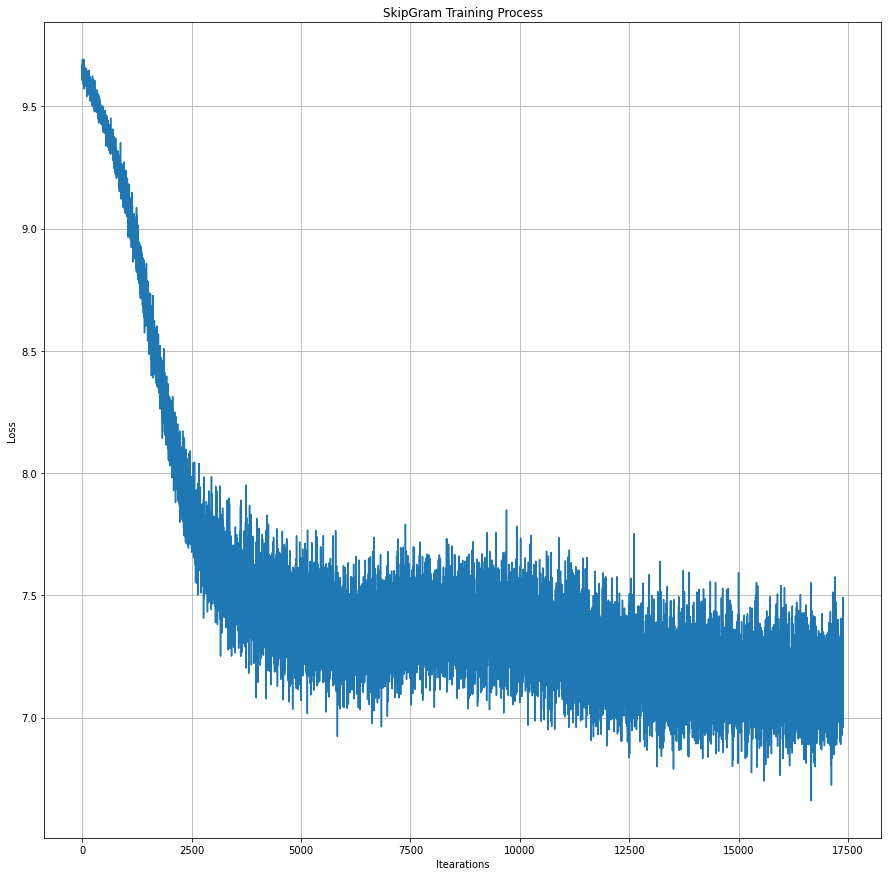

In [80]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [65]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [66]:
embedding_matrix = model.in_embedding.weight.detach()

In [67]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [68]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.5900339484214783

In [69]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.7745673656463623

In [70]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.7490051984786987

In [71]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.36298704147338867

In [72]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "переполнять" равна 0.062'

In [73]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [74]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [75]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.039s...
[t-SNE] Computed neighbors for 13076 samples in 9.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [76]:
top_words = [a for a,_ in top_sorted_freq]

In [77]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

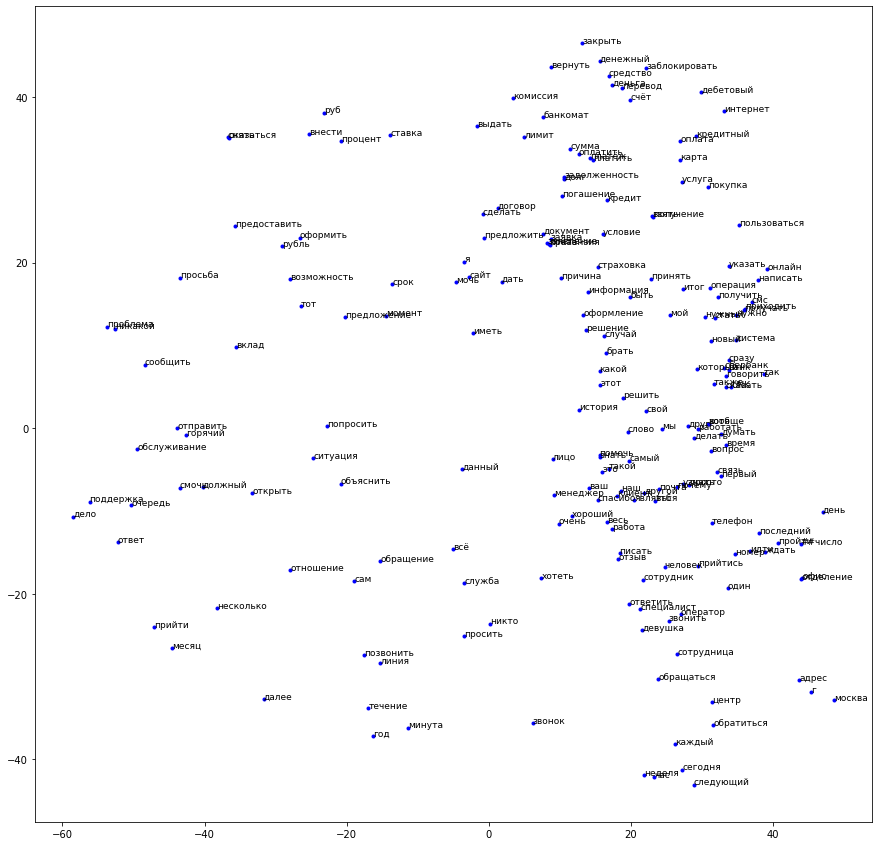

In [81]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()